<a href="https://colab.research.google.com/github/UN-GCPDS/curso_IA_CHEC/blob/main/Modulo2/cuadernos/reduccion_dimension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)
# **MÓDULO 2: APRENDIZAJE SUPERVISADO Y NO SUPERVISADO**

## **Descripción**

Aplicación de modelos de aprendizaje de máquina para el estudio de datos tabulares por métodos supervisados y no supervisados.

### **Profesor - Sesión 3 y 4:** Diego Armando Pérez Rosero
### **Monitores - Sesión 3 y 4:** Danna Valentina Salazar Dubois, Juan Camilo Lugo Rojas Y Lucas Miguel Iturriago Salas

In [ ]:
# @title
%%capture
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap
!pip install gdown --quiet # Instalar gdown si no está instalado
!pip install datashader bokeh holoviews   --quiet
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.localbiplot.git --quiet

# Para crear widgets interactivos y visualizaciones interactivas
from ipywidgets import interact, IntSlider, FloatSlider, Dropdown, VBox, Layout, Output, interactive_output, SelectMultiple, Button, Label
from IPython.display import display, clear_output

# Para visualización
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import gcpds.localbiplot as lb

# Para procesamiento de datos y machine learning
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import make_swiss_roll, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import umap
import umap.plot

# Para manipulación de archivos y datos en disco
from tempfile import mkdtemp
import os.path as path
import os
import time
import zipfile
import gdown

# Reemplaza 'YOUR_FILE_ID' con el ID correcto del archivo .zip en Google Drive
file_id = '1DmMNxDSnNjJiO0wfqUWt0po5kwbbKNH3'

# Descargar el archivo .zip desde Google Drive usando gdown

gdown.download(f'https://drive.google.com/uc?export=download&id={file_id}', 'local_biplot.zip', quiet=False)

# Descomprimir el archivo .zip

with zipfile.ZipFile('local_biplot.zip', 'r') as zip_ref:
    zip_ref.extractall('.')  # Extrae los archivos en el directorio actual

# **Visualización de datos**

- Se presentan los conceptos y simulaciones básicas relacionadas con técnicas clásicas lineales y no lineales de reducción de dimensión.
## **Análisis de componentes de principales - Principal Component Analysis (PCA)**

![gifpca](https://miro.medium.com/v2/resize:fit:1400/format:webp/0*TXIbCytfgo5p5hty.gif)


- PCA busca un espacio de menor dimensión que preserve la mayor cantidad de variabilidad posible desde el espacio original (alta dimensión).

- Desde una perspectiva generativa, PCA asume que los datos $\mathbf{X} \in \mathbb{R}^{N \times P}$ son generados desde un espacio de baja dimensión (espacio latente) $\mathbf{Z} \in \mathbb{R}^{N \times M}$, donde $M < P$:

\begin{equation}
\mathbf{X} = \mathbf{Z} \mathbf{W}^T,
\end{equation}

- $\mathbf{Z}=\mathbf{X}\mathbf{W}$: matriz de baja dimensión.
- $\mathbf{W} \in \mathbb{R}^{P \times M}$: componentes principales (loading vectors).

El problema de optimización desde el punto de vista generativo:

\begin{align}
\mathbf{W}^*=&\arg\min_\mathbf{W} \|\mathbf{X}-\mathbf{Z} \mathbf{W}^T\|_F \\
   \text{s.t.} & \quad \mathbf{W}\mathbf{W}^\top  = \mathbf{I}
\end{align}



- PCA también puede resolverse maximizando la varianza de los datos proyectados.

- Asumiendo datos centralizados $\mathbf{X}$, la covarianza $\mathbf{\Sigma}\in \mathbb{R}^{P \times P}$ se define como:

\begin{equation}
\mathbf{\Sigma} = \frac{1}{N} \mathbf{X}^T \mathbf{X}.
\end{equation}

- El problema de optimización de PCA se puede reescribir como:

\begin{align}
\mathbf{W}^*=&\arg\max_\mathbf{W} \text{tr}(\mathbf{W}^T \mathbf{\Sigma} \mathbf{W}),\\
 \text{s.t.} & \quad \mathbf{W}\mathbf{W}^\top  = \mathbf{I}
\end{align}


- La solución del problema se centra en los $M$ vectores propios de la matriz de covarianza, correspodiente a los $M$ valores propios más altos.

- Ver la demostración [PCA generativo a PCA por varianza](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/otros/DemostracionPCA.pdf).


### **Rollo Suizo**

**Ejemplo:** Construyamos un conjunto de datos 3D del famoso dato sintético rollo Suizo - Swiss Roll.

In [ ]:
# @title

class SwissRollVisualizer:
    def __init__(self, n_samples=1000, noise=0.2):
        self.n_samples = n_samples
        self.noise = noise
        self.X = None
        self.t = None

    def generate_swiss_roll(self):
        self.X, self.t = make_swiss_roll(n_samples=self.n_samples, noise=self.noise, random_state=42)

    def plot_swiss_roll(self, n_samples, noise, elev, azim):
        self.n_samples = n_samples
        self.noise = noise
        self.generate_swiss_roll()

        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(self.X[:, 0], self.X[:, 1], self.X[:, 2], c=self.t, cmap=plt.get_cmap('Spectral'))
        ax.view_init(elev=elev, azim=azim)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

# Instanciar la clase
visualizer = SwissRollVisualizer()

# Uso de interact con la instancia del visualizador
interact(visualizer.plot_swiss_roll,
         n_samples=IntSlider(min=100, max=5000, step=100, value=1000, description='Samples:'),
         noise=FloatSlider(min=0.0, max=1.0, step=0.05, value=0.2, description='Noise:'),
         elev=IntSlider(min=0, max=90, step=5, value=10, description='Elevation:'),
         azim=IntSlider(min=-180, max=180, step=5, value=-75, description='Azimuth:'))


interactive(children=(IntSlider(value=1000, description='Samples:', max=5000, min=100, step=100), FloatSlider(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

**NOTA:** PCA supone que el conjunto de datos se centra en el origen. Como veremos, las clases de PCA de Scikit-Learn se encargan de centrar los datos por usted. Sin embargo, si implementa PCA usted mismo, o si usa otras bibliotecas, **no olvide centrar los datos primero**, incluso considere aplicar normalización zscore.

### **Usando PCA de scikit-learn**

El siguiente código aplica PCA para reducir la dimensionalidad del conjunto de datos a dos dimensiones (tenga en cuenta que automáticamente se encarga de centrar los datos):

Tenga en cuenta que ejecutar PCA varias veces en conjuntos de datos ligeramente diferentes puede dar como resultado resultados diferentes. En general, la única diferencia es que algunos ejes pueden voltearse.

**Nota**: el problema de optimización de PCA que incluye costo cuadrático y restricciones cuadráticas, que da como resultado un problema no convexo.

####  **Aplicación de PCA**

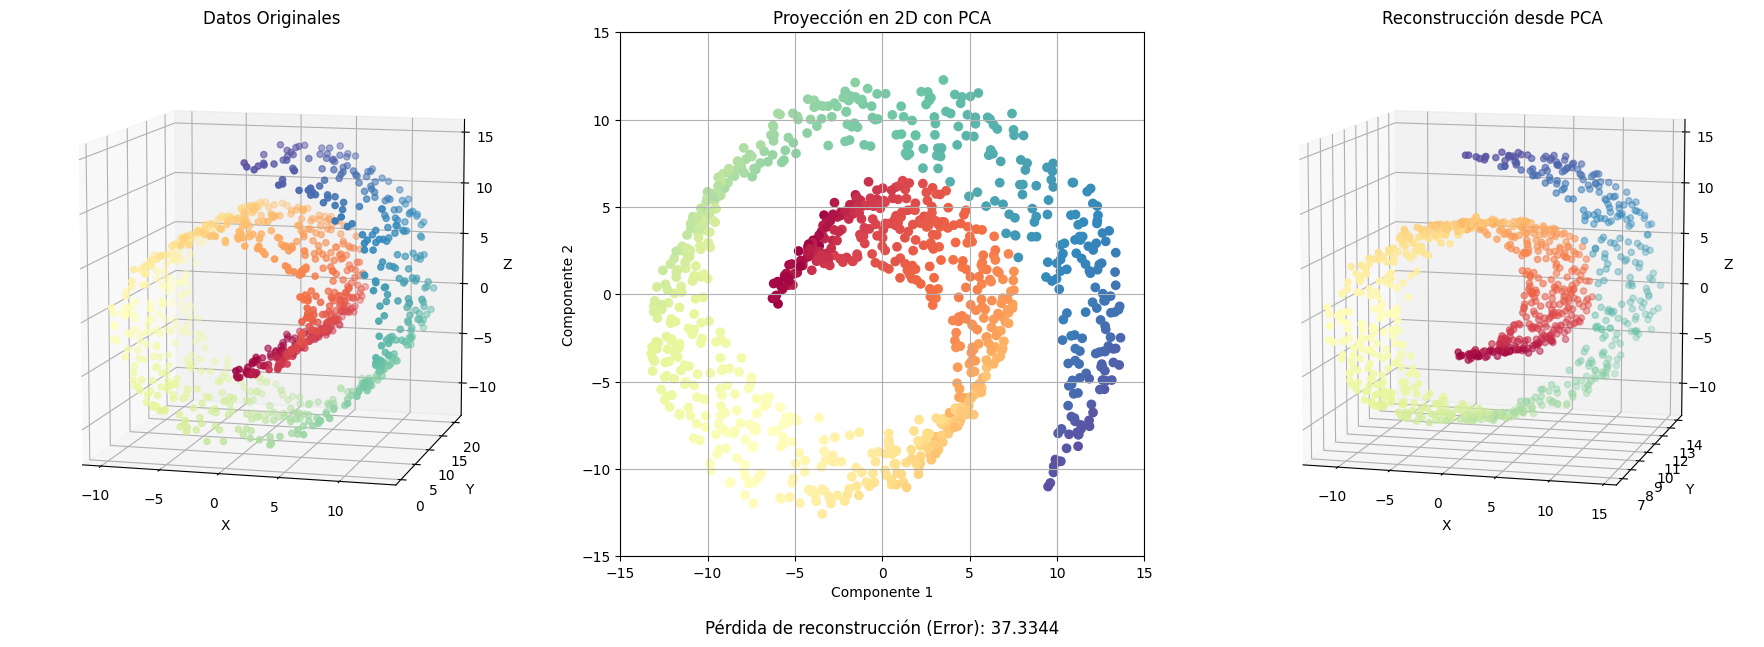

In [ ]:
# @Aplicación de PCA
def plot_pca_analysis(X, t):
    # Aplicar PCA para reducir a 2D
    pca = PCA(n_components=2)
    Y2D = pca.fit_transform(X)

    # Reconstruir los datos a partir de los componentes principales
    X3D_inv = pca.inverse_transform(Y2D)

    # Calcular la pérdida de reconstrucción
    reconstruction_loss = np.mean(np.sum(np.square(X3D_inv - X), axis=1))

    # Configurar el layout de la figura con proporciones específicas
    fig = plt.figure(figsize=(18, 6))

    # Visualización de los datos originales en 3D
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='Spectral')
    ax1.set_title('Datos Originales')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.view_init(elev=10, azim=-75)
    ax1.set_box_aspect([1, 1, 1])  # Igualar aspecto de los ejes

    # Visualización de la proyección 2D
    ax2 = fig.add_subplot(132)
    ax2.scatter(Y2D[:, 0], Y2D[:, 1], c=t, cmap='Spectral')
    ax2.set_title('Proyección en 2D con PCA')
    ax2.set_xlabel('Componente 1')
    ax2.set_ylabel('Componente 2')
    ax2.grid(True)
    ax2.set_aspect('equal', adjustable='box')  # Ajustar el aspecto de la gráfica 2D

    # Ajustar los límites para que se vean similares en tamaño
    ax2.set_xlim(-15, 15)
    ax2.set_ylim(-15, 15)

    # Visualización de la reconstrucción en 3D
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.scatter(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], c=t, cmap='Spectral')
    ax3.set_title('Reconstrucción desde PCA')
    ax3.set_xlabel('X')
    ax3.set_ylabel('Y')
    ax3.set_zlabel('Z')
    ax3.view_init(elev=10, azim=-75)
    ax3.set_box_aspect([1, 1, 1])  # Igualar aspecto de los ejes

    # Mostrar el error de reconstrucción en la parte inferior
    plt.figtext(0.5, -0.05, f"Pérdida de reconstrucción (Error): {reconstruction_loss:.4f}", ha="center", fontsize=12)

    # Ajustar el espacio entre subplots para uniformidad
    plt.tight_layout(pad=2.0)
    plt.show()
    return pca

# Uso de la función con los datos del visualizador
X = visualizer.X
t = visualizer.t
pca= plot_pca_analysis(X, t)


Las reconstrucciones de ambos métodos **no son idénticas** porque la clase PCA de Scikit-Learn se encarga automáticamente de revertir el centrado medio, *pero si restamos la media, obtenemos la misma reconstrucción*.

El objeto PCA da acceso a los componentes principales que calculó:

In [ ]:
pca.components_

array([[ 0.56791312,  0.15670748,  0.80803308],
       [ 0.77712377,  0.2213858 , -0.5891239 ]])

### **Varianza retenida (explicada)**

- El valor propio relacionado con cada compoenente, codifica la varianza retenida del espacio de entrada.

Por ejemplo, veamos las razones de varianza explicadas de los dos primeros componentes del conjunto de datos 3D representados

In [ ]:
pca.explained_variance_ratio_

array([0.40782396, 0.3020019 ])


Esto le indica que **el 40.8% de la varianza del conjunto de datos se encuentra a lo largo del primer eje**, y el **30.2% se encuentra a lo largo del segundo eje**.

### **Determinar el número de dimensiones proyectas**

El siguiente código calcula PCA sin reducir la dimensionalidad, luego calcula el número mínimo de dimensiones requeridas para preservar el 95% de la variación del conjunto de entrenamiento (se utilizará la base de datos Mnist que tiene 784 dimensiones de entrada).

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


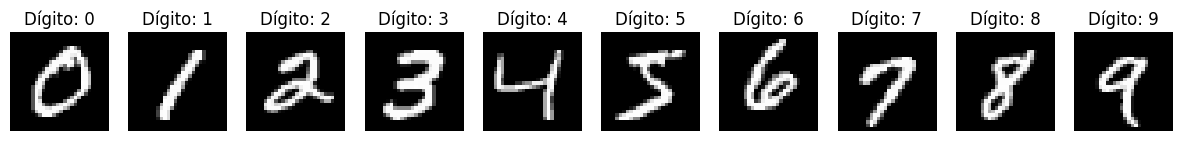

In [ ]:
# @title
# Descargar el conjunto de datos MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Aplanar cada imagen de 28x28 a un vector de 784 elementos
X_train = x_train.reshape(x_train.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

# Inicializar una lista para guardar las imágenes representativas de cada dígito (0-9)
representative_images = []

# Iterar por cada dígito (0-9)
for digit in range(10):
    # Encontrar el primer índice donde aparece el dígito actual
    index = np.where(y_train == digit)[0][0]
    # Guardar la imagen correspondiente
    representative_images.append(x_train[index])

# Crear una figura con subplots para mostrar los dígitos
fig, axes = plt.subplots(1, 10, figsize=(15, 3))

# Iterar sobre los dígitos (0-9) y sus imágenes representativas
for i, ax in enumerate(axes):
    # Mostrar la imagen en escala de grises
    ax.imshow(representative_images[i], cmap='gray')
    # Poner el título del dígito correspondiente
    ax.set_title(f'Dígito: {i}')
    # Quitar los ejes para mayor claridad
    ax.axis('off')

# Mostrar la figura
plt.show()

### **Varianza acumulada**

In [ ]:
# @title

# Aplicar PCA al conjunto de entrenamiento
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

def plot_pca_components(varianza_objetivo):
    # Encontrar el número de componentes necesarios para explicar la varianza objetivo
    d = np.argmax(cumsum >= varianza_objetivo) + 1

    # Graficar la varianza explicada acumulada
    plt.figure(figsize=(10, 6))
    plt.plot(cumsum, linewidth=2)
    plt.axhline(y=varianza_objetivo, color='r', linestyle='--')
    plt.axvline(x=d, color='g', linestyle='--')
    plt.xlabel('Número de componentes principales')
    plt.ylabel('Varianza explicada acumulada')
    plt.title(f'{d} componentes para {varianza_objetivo:.0%} varianza explicada')
    plt.grid(True)
    plt.show()

# Uso de interact para ajustar la proporción de varianza explicada
interact(plot_pca_components,
         varianza_objetivo=FloatSlider(min=0.1, max=1, step=0.05, value=0.5, description='Varianza objetivo:'))

interactive(children=(FloatSlider(value=0.5, description='Varianza objetivo:', max=1.0, min=0.1, step=0.05), O…

<function __main__.plot_pca_components(varianza_objetivo)>

También podemos establecer *n_components = d* y ejecutar PCA nuevamente. Sin embargo, hay una opción mucho mejor: en lugar de especificar el número de componentes principales que desea conservar, puede establecer *n_components* para que sea flotante entre 0.0 y 1.0, lo que indica la relación de varianza que desea conservar:

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_

154

In [ ]:
np.sum(pca.explained_variance_ratio_)

0.9501960192613033

### **Kernel PCA**

- El algoritmo [Kernel PCA](https://en.wikipedia.org/wiki/Kernel_principal_component_analysis) permite calcular los componentes principales a partir de un mapeo no lineal basado en funciones núcleo.

In [ ]:
# @title
# Supongamos que los datos ya están cargados en X y t
X = np.array(visualizer.X)  # Asegurarse de que X es un array de NumPy
t = visualizer.t

def plot_swiss_roll(X, X_reduced, t, title):
    # Gráfica de los datos originales y la proyección 2D
    fig = plt.figure(figsize=(15, 6))

    # Gráfica Original
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap='Spectral')
    ax1.set_title("Datos Originales")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.view_init(elev=10, azim=-75)

    # Gráfica de la proyección 2D
    ax2 = fig.add_subplot(122)
    scatter = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='Spectral')
    ax2.set_title(title)
    ax2.set_xlabel('Primera Componente')
    ax2.set_ylabel('Segunda Componente')
    plt.colorbar(scatter)

    plt.tight_layout()
    plt.show()

def interactive_kernel_pca(kernel, gamma=0.1, coef0=1.0):
    # Fijar el número de componentes a 2
    n_components = 2

    start_time = time.time()
    kernel_pca = KernelPCA(n_components=n_components, kernel=kernel, gamma=gamma, coef0=coef0, fit_inverse_transform=True, random_state=42)
    X_reduced = kernel_pca.fit_transform(X)
    pca_time = time.time() - start_time
    title = f"Proyección 2D Kernel PCA\n(Kernel={kernel}, Gamma={gamma}, Coef0={coef0}, Time: {pca_time:.2f}s)"

    # Mostrar las gráficas
    plot_swiss_roll(X, X_reduced, t, title)

# Widgets para seleccionar el kernel y ajustar hiperparámetros
kernel_widget = Dropdown(options=['linear', 'poly', 'rbf', 'sigmoid', 'cosine'], value='linear', description='Kernel:')
gamma_widget = FloatSlider(min=1e-3, max=0.08, step=0.001, value=8.9e-5, description='Gamma:', layout=Layout(visibility='hidden'))
coef0_widget = FloatSlider(min=0.0, max=18.0, step=1, value=1.0, description='Coef0:', layout=Layout(visibility='hidden'))

# Output widget para mostrar las gráficas
output = Output()

# Función para mostrar y ocultar controles de hiperparámetros según el kernel seleccionado
def update_controls(change):
    # Ocultar por defecto
    gamma_widget.layout.visibility = 'hidden'
    coef0_widget.layout.visibility = 'hidden'

    # Mostrar controles específicos según el kernel seleccionado
    if kernel_widget.value == 'rbf':
        gamma_widget.layout.visibility = 'visible'
    elif kernel_widget.value == 'sigmoid':
        gamma_widget.layout.visibility = 'visible'
        coef0_widget.layout.visibility = 'visible'
    elif kernel_widget.value == 'poly':
        coef0_widget.layout.visibility = 'visible'

# Observador para actualizar los controles al cambiar el kernel
kernel_widget.observe(update_controls, names='value')

# Inicializar los controles la primera vez
update_controls(None)

# Función para ejecutar Kernel PCA con los parámetros seleccionados
def run_kernel_pca(kernel, gamma, coef0):
    with output:
        clear_output(wait=True)
        interactive_kernel_pca(kernel, gamma, coef0)

# Configurar la interfaz interactiva
interactive_controls = interactive_output(run_kernel_pca, {
    'kernel': kernel_widget,
    'gamma': gamma_widget,
    'coef0': coef0_widget
})

# Contenedor principal
ui = VBox([kernel_widget, gamma_widget, coef0_widget, output])

# Mostrar la interfaz
display(ui)

La Figura muestra el rollo suizo, reducido a dos dimensiones usando un núcleo lineal (equivalente a simplemente usar la clase *PCA*), un núcleo RBF y un núcleo sigmoide (Logístico).

### **kPCA: Definiendo el kernel y sus hiperparámetros**

- Como kPCA es un algoritmo de aprendizaje no supervisado, *no existe una medida de rendimiento obvia para ayudarlo a seleccionar los mejores valores de kernel e hiperparámetros*.

- Sin embargo, la reducción de dimensionalidad es a menudo un paso de preparación para una tarea de aprendizaje supervisada (por ejemplo, clasificación), por lo que simplemente puede usar la **búsqueda de cuadrícula** para seleccionar el núcleo y los hiperparámetros conducen al mejor rendimiento en esa tarea.

**Ejemplo:** el siguiente código crea una guía de dos pasos para la clasificación de la base de datos Mnist.

- Primero reduciendo la dimensionalidad a dos dimensiones usando kPCA, luego aplicando Regresión logística para la clasificación.

- Se utiliza *GridSearchCV* para encontrar el mejor valor de kernel y gamma para kPCA para obtener la mejor precisión de clasificación al final de la guía:

Los mejores kernels e hiperparámetros están disponibles a través de la variable *best_params_*:

#### **Busqueda de hiperparametros**

In [ ]:
# @title

# Importación necesaria de widgets y otros módulos
from ipywidgets import Checkbox, HBox, VBox, FloatRangeSlider, Button, Output, Label
from sklearn.decomposition import KernelPCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
# Widget FloatRangeSlider para configurar el rango de gamma
gamma_range_slider = FloatRangeSlider(min=0.01, max=0.1, step=0.001, value=(0.03, 0.05), description='Gamma Range:')

# Widget de checkboxes para seleccionar los kernels
rbf_checkbox = Checkbox(value=True, description='rbf', disabled=False)
sigmoid_checkbox = Checkbox(value=True, description='sigmoid', disabled=False)
cosine_checkbox = Checkbox(value=True, description='cosine', disabled=False)

search_button = Button(description="Buscar")
output = Output()

# Función para obtener la selección de los checkboxes
def get_selected_kernels():
    selected_kernels = []
    if rbf_checkbox.value:
        selected_kernels.append('rbf')
    if sigmoid_checkbox.value:
        selected_kernels.append('sigmoid')
    if cosine_checkbox.value:
        selected_kernels.append('cosine')
    return selected_kernels

# Función para realizar la búsqueda de hiperparámetros y evaluar el error
def perform_grid_search(gamma_range, kernels):
    with output:
        clear_output(wait=True)
        if len(kernels) == 0:
            print("Por favor, selecciona al menos un kernel.")
            return

        gamma_min, gamma_max = gamma_range

        # Configuración del Pipeline y GridSearchCV
        clf = Pipeline([
            ("kpca", KernelPCA(n_components=2)),
            ("log_reg", LogisticRegression(solver="lbfgs", max_iter=1000))
        ])

        # Rango de parámetros basado en la entrada del usuario
        param_grid = [{
            "kpca__gamma": np.linspace(gamma_min, gamma_max, 10),
            "kpca__kernel": kernels
        }]

        # Realizar la búsqueda
        grid_search = GridSearchCV(clf, param_grid, cv=3)
        grid_search.fit(X_train[:500], y_train[:500])

        # Imprimir los mejores parámetros
        best_params = grid_search.best_params_
        print("Mejores parámetros:", best_params)

        # Calcular y mostrar el error de reconstrucción con los mejores parámetros
        best_gamma = best_params["kpca__gamma"]
        best_kernel = best_params["kpca__kernel"]

        # Reconstrucción con los mejores parámetros obtenidos
        kpca = KernelPCA(n_components=2, kernel=best_kernel, gamma=best_gamma, fit_inverse_transform=True)
        X_reduced = kpca.fit_transform(X_train)  # Usar X_train para la reducción
        X_preimage = kpca.inverse_transform(X_reduced)
        mse = mean_squared_error(X_train, X_preimage)  # Comparar contra X_train
        print(f"Error de reconstrucción (MSE): {mse}")

# Función para manejar la interacción del botón
def on_search_button_clicked(b):
    selected_kernels = get_selected_kernels()
    perform_grid_search(gamma_range_slider.value, selected_kernels)

# Vincular la función al botón
search_button.on_click(on_search_button_clicked)

# Organizar los checkboxes en una fila (HBox)
kernel_checkboxes = HBox([rbf_checkbox, sigmoid_checkbox, cosine_checkbox])

# Organizar la interfaz
ui = VBox([
    Label("Seleccione los rangos de gamma y los kernels para la búsqueda:"),
    gamma_range_slider,
    Label("Seleccione los kernels:"),
    kernel_checkboxes,
    search_button,
    output
])

# Mostrar la interfaz
display(ui)


## **t-distributed stochastic neighborhood embedding**

- [t-SNE](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf?fbclid=IwA) es de los algoritmos más potentes en reducción de dimensión dado que permite unir los principios de manifold learning y probabilidades, para lidear con el problema de concentración de las normas (métricas en espacios de alta dimensión se distribuyen muy diferente a métricas en espacios de baja dimensión).


![gifpca](https://learnopencv.com/wp-content/uploads/2022/11/tsne.gif)



- t-SNE busca minimizar la diferencia entre las funciones de probabilidad del espacio original (alta dimensión) y el espacio reducido (baja dimensión), evitando el problema de la concentración de la norma.


- La similitud es modelada como una distribución Gaussiana, tal que la probabilidad condicional $p_{n'|n}$ que define si  $\mathbf{x}_n$ selecciona a $\mathbf{x}_{n'}$ como su vecino es:

\begin{equation}
p_{n'|n} = \frac{\exp(-\|\mathbf{x}_n - \mathbf{x}_{n'}\|^2 / 2\sigma_n^2)}{\sum_{k \neq n} \exp(-\|\mathbf{x}_n - \mathbf{x}_k\|^2 / 2\sigma_n^2)},
\end{equation}

donde $\sigma_n\in \mathbb{R}^+$.

La probabilidad conjunta se puede definir como :

\begin{equation}
p_{nn'} = \frac{p_{n'|n} + p_{n|n'}}{2N}.
\end{equation}



- Para el espacio de baja dimensión se utiliza un distribución t-Student con un grado de libertad (distribución de Cauchy).

- La probabilidad conjunta $q_{nn'}$ que modela si $\mathbf{y}_n$ y $\mathbf{z}_{n'}$ están cercanos es dada por:

\begin{equation}
q_{nn'} = \frac{(1 + \|\mathbf{z}_n - \mathbf{z}_{n'}\|^2)^{-1}}{\sum_{k \neq l} (1 + \|\mathbf{z}_k - \mathbf{z}_l\|^2)^{-1}}.
\end{equation}


- t-SNE minimiza la divergencia de  Kullback-Leibler (KL) entre $P = \{p_{nn'}\}$ y $Q = \{q_{nn'}\}$:

\begin{equation}
\text{KL}(P \| Q) = \sum_{n \neq n'} p_{nn'} \log \left( \frac{p_{nn'}}{q_{nn'}} \right).
\end{equation}

- La minización se resuelve convencionalmente por métodos de gradiente.

- Es importante resaltar que el ancho de bando en el espacio de alta dimensión se fija por muestra, fijando un valor de entropia común (perplexity).




## **Uniform Manifold Approximation and Projection (UMAP)**

![gifumap](https://umap-learn.readthedocs.io/en/latest/_images/aligned_umap_pendigits_anim.gif)

- UMAP es una técnica de reducción de dimensión que modela el espacio de alta dimensión como estructura topológica difusa y la optimiza en el espacio de baja dimensión preservando distancias globales y locales.

- UMAP construye un grafo ponderado para representar la estructura topológica difusa.

- La probabilidad $p_{nn'}$ que representa el peso del borde entre $\mathbf{x}_n$ and $\mathbf{x}_{n'}$ esta dada por:

\begin{equation}
p_{nn'} = \exp\left(-\frac{\|\mathbf{x}_n - \mathbf{x}_{n'}\| - \rho_n}{\sigma_n}\right),
\end{equation}

- $\rho_n$ es la distancia al vecino más cercano de $\mathbf{x}_n$, lo que asegura que las distancias locales no se ven afectadas por ruido.
    
- $\sigma_n$ se determina por una un número fijo de vecinos.


- La relación difusa se vuelve simétrica como:

\begin{equation}
\tilde{p}_{nn'} = p_{nn'} + p_{n'n} - p_{nn'} p_{n'n}.
\end{equation}



- Las relaciones en el espacio de baja dimensión se fijan mediante una distribución t-student de cola pesada:

\begin{equation}
q_{nn'} = \left(1 + a \|\mathbf{z}_n - \mathbf{z}_{n'}\|^{2b}\right)^{-1},
\end{equation}

con $a$ y $b$ como parámetros de la distribución. Generalmente se fijan en 1.


- UMAP minimiza la entropía cruzada :

\begin{equation}
C(P;Q) = \sum_{n \neq n'} \left( -\tilde{p}_{nn'} \log(q_{nn'}) - (1 - \tilde{p}_{nn'}) \log(1 - q_{nn'}) \right).
\end{equation}

- Convencionalmente se utilizan métodos de gradiente para resolver la optimización.

### **Reducción de dimensionalidad comparación**

In [ ]:
# @title
X = np.array(visualizer.X[:200])  # Asegurarse de que X es un array de NumPy
t = visualizer.t[:200]

# Widgets para seleccionar el método y sus parámetros
method_widget = Dropdown(
    options=["t-SNE", "UMAP"],
    value="UMAP",
    description='Method:'
)

# Widget para perplexity de t-SNE
perplexity_widget = FloatSlider(
    value=30.0,
    min=5.0,
    max=100.0,
    step=1.0,
    description='Perplexity:',
    disabled=False,
    layout=Layout(visibility='hidden')
)

# Widgets para UMAP
n_neighbors_widget = IntSlider(
    value=40,
    min=2,
    max=200,
    step=1,
    description='n_neighbors:',
    disabled=False,
    layout=Layout(visibility='hidden')
)

min_dist_widget = FloatSlider(
    value=0.2,
    min=0.0,
    max=0.99,
    step=0.01,
    description='min_dist:',
    disabled=False,
    layout=Layout(visibility='hidden')
)

apply_button = Button(description="Aplicar")
output = Output()

# Función para mostrar/ocultar widgets según el método seleccionado
def update_widgets(change):
    if change.new == "t-SNE":
        perplexity_widget.layout.visibility = 'visible'
        n_neighbors_widget.layout.visibility = 'hidden'
        min_dist_widget.layout.visibility = 'hidden'
    else:  # UMAP
        perplexity_widget.layout.visibility = 'hidden'
        n_neighbors_widget.layout.visibility = 'visible'
        min_dist_widget.layout.visibility = 'visible'

method_widget.observe(update_widgets, names='value')

# Función para aplicar la reducción de dimensionalidad y visualizar los resultados
def apply_dimensionality_reduction(method, perplexity, n_neighbors, min_dist):
    with output:
        clear_output(wait=True)
        if method == "t-SNE":
            tsne = TSNE(n_components=2,
                       perplexity=perplexity,
                       random_state=42)
            X_reduced = tsne.fit_transform(X)
            title = f"t-SNE (perplexity={perplexity})"
        else:  # UMAP
            umap_reducer = umap.UMAP(
                n_components=2,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                random_state=42
            )
            X_reduced = umap_reducer.fit_transform(X)
            title = f"UMAP (n_neighbors={n_neighbors}, min_dist={min_dist})"

        # Visualizar los resultados en 2D
        plt.figure(figsize=(10, 8))
        plt.title(title, fontsize=14)
        scatter = plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap='Spectral')
        plt.colorbar(scatter)
        plt.xlabel("$z_1$", fontsize=18)
        plt.ylabel("$z_2$", fontsize=18)
        plt.grid(True)
        plt.show()

# Función para manejar la interacción del botón
def on_apply_button_clicked(b):
    apply_dimensionality_reduction(
        method_widget.value,
        perplexity_widget.value,
        n_neighbors_widget.value,
        min_dist_widget.value
    )

# Vincular la función al botón
apply_button.on_click(on_apply_button_clicked)

# Organizar la interfaz
ui = VBox([
    Label("Seleccione el método de reducción de dimensionalidad y sus parámetros:"),
    method_widget,
    perplexity_widget,
    n_neighbors_widget,
    min_dist_widget,
    apply_button,
    output
])

# Inicializar la visibilidad de los widgets
update_widgets(type('Change', (), {'new': method_widget.value})())

# Mostrar la interfaz
display(ui)